# <center> PREDICTING MUSIC TASTE WITH SPOTIFY </center>

## 1 - Introduction 


I've always wondered what makes up a person's music taste. We all have our favorite artists or genres – but certainly there's more to it than that. Do you like a song because of its lyrics? Beacuse of its tempo or rhythm? Because of the way in which it was produced? Because it reminds you of a certain memory?

The answer is... all of the above! We all like songs for different reasons. When it comes to describing our own music taste, there isn't one standard way to do so. But what if we could use machine learning to analyze all the different reasons we like songs – and predict which songs we would like or dislike? In other words, is there a way to use data and machine learning to better understand a person's music taste?

------ 

In this project, I use Spotify-generated metrics to predict whether a friend will like a given song or not. I analyze the music data of a friend and avid Spotify user, Antoine, who has collected 2370 songs over the past few months and has classified each song into one of two categories – liked or disliked. Each song is described by **23** features, generated by Spotify and retrieved using its API. These features include musical measures created by Spotify developers, like danceability and speechiness. They also include several musical qualities, like tempo, duration and time signature. Metrics regarding artist popularity and song popularity are also included. 

In exploring this data and testing various classifiers, I analyze the predictive ability of these Spotify-generated metrics. Could traditional musical measures be used to identify a person's music taste? What about popularity scores generated by Spotify? 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
import statistics
from scipy import stats
from scipy import stats, special
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection, tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from seaborn import pairplot, heatmap
from sklearn.feature_selection import SelectKBest, f_classif, chi2

import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

## 2 - Data Collection

For a few months, Antoine populated two playlists on Spotify – 'Liked' and 'Disliked' – with, well, songs he liked and those he disliked. As an avid music listener, it didn't take very long for the playlists to fill up. 

Once the playlists were sufficiently filled, with around 1000 songs each, I needed to transform them into usable data. Fortunately enough, there's a lightweight python library called **spotipy**, which allows easy access to the Spotify Web API. With a few lines of code, I was able to extract the songs from the playlists, with 23 features for each song, and create a pandas dataframe without any null values. The cleaning was minimal and mostly consisted of changing the data type or unit type of individual features.

Below is the initial dataframe I retrieved, before cleaning.

In [5]:
adf = pd.read_csv('../datasets/music_prefs.csv', index_col=0)

adf.shape

(2376, 20)

In [6]:
adf.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_popularity,explicit,artists,genres,album_popularity,artist_popularity,like
0,0.489,0.516,1,-8.921,0,0.3080,0.4460,0.00000,0.0832,0.172,149.611,95160,4,49,True,['Damso'],"[['belgian hip hop', 'french hip hop', 'pop ur...",[66],[75],1
1,0.662,0.436,9,-12.900,0,0.0651,0.8530,0.00000,0.0624,0.627,92.857,178293,4,47,False,['Jean Leloup'],"[['indie quebecois', 'pop quebecois', 'rock qu...",[45],[51],1
2,0.517,0.928,4,-8.881,0,0.0448,0.0145,0.02330,0.4810,0.728,90.593,172707,4,31,False,['Jean Leloup'],"[['indie quebecois', 'pop quebecois', 'rock qu...",[38],[51],1
3,0.820,0.407,4,-11.301,0,0.0387,0.7710,0.00544,0.1130,0.770,125.642,138027,4,42,False,['Jean Leloup'],"[['indie quebecois', 'pop quebecois', 'rock qu...",[45],[51],1
4,0.452,0.579,2,-11.085,1,0.0476,0.0153,0.89300,0.6370,0.929,84.615,213760,4,61,False,['Khruangbin'],"[['funk', 'indie soul', 'neo-psychedelic', 'so...",[68],[72],1


### *Data Preparation*

Below are the steps I took to prepare the data:

- **One-hot encoding** - variables for six given genres
- **Dropping columns** - artists, genres
- **Changing data types** - 'explicit' from boolean to numeric, 'artist popularity' and 'album popularity' from string to int
- **Changing unit types** - 'duration' in milliseconds to minutes

The most notable data transformation I performed was one-hot encoding variables for six genres – pop, rock,  R&B, hip hop, funk and rap. I did this because I wanted to account for genre as a feature in the predictive model, but wanted to keep it simple with just six of the most popular genres today. To be honest, a predictive model could have been built using solely song genres on Spotify; they have sub-genres and sub-sub-genres I've never even heard of (Indietronica? British Invasion??)

Once this was done, the data was formatted and ready to be used by the models.

In [7]:
adf['r&b'] = 0
adf['pop'] = 0
adf['rap'] = 0
adf['hip hop'] = 0
adf['funk'] = 0
adf['rock'] = 0

for i in range(len(adf)):    
    n = adf.loc[i, 'album_popularity']
    n = n[1:-1].split(',')
    n = int(n[0])
    adf.loc[i, 'album_popularity'] = n   
    
    x = adf.loc[i, 'artist_popularity']
    x = x[1:-1].split(',')

    for j in range(len(x)):
        x[j] = int(x[j])
        
    x = statistics.mean(x)
    adf.loc[i, 'artist_popularity'] = x

    genres = adf.loc[i, 'genres']
    if 'hip hop' in genres:
        adf.loc[i, 'hip hop'] = 1
    if 'pop' in genres:
        adf.loc[i, 'pop'] = 1
    if 'rap' in genres:
        adf.loc[i, 'rap'] = 1
    if 'r&b' in genres:
        adf.loc[i, 'r&b'] = 1
    if 'funk' in genres:
        adf.loc[i, 'funk'] = 1
    if 'rock' in genres:
        adf.loc[i, 'rock'] = 1

In [8]:
adf = adf.drop(['artists', 'genres'], axis=1)

adf['explicit'] = (adf['explicit']==True).astype(int)

adf['duration_min'] = (adf['duration_ms']/(1000*60))%60
adf = adf.drop('duration_ms',axis = 1)

### *The Final Dataframe*

The final dataset I worked with contains 2376 songs and 23 predictors. The target variable is 'like', which indicates whether the song is liked or not by Antoine. 

**Columns/Predictors:**
- Danceability
- Energy
- Key
- Loudness
- Mode
- Speechiness
- Acousticness
- Instrumentalness
- Liveness
- Valence 
- Tempo
- Time Signature
- Explicit
- Duration (minutes)

- Song Popularity
- Album Popularity
- Artist Popularity

- R&B
- Pop
- Rap
- Hip hop
- Funk
- Rock

**Target Variable:** like 
- Indicates whether or not the song is liked by Antoine (1 if liked, 0 if disliked)

------ 

(For more details on the predictors, you can take a look at the [Spotify API documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)!)

In [9]:
adf.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,album_popularity,artist_popularity,like,r&b,pop,rap,hip hop,funk,rock,duration_min
0,0.489,0.516,1,-8.921,0,0.3080,0.4460,0.00000,0.0832,0.172,...,66,75,1,0,1,1,1,0,0,1.586000
1,0.662,0.436,9,-12.900,0,0.0651,0.8530,0.00000,0.0624,0.627,...,45,51,1,0,1,0,0,0,1,2.971550
2,0.517,0.928,4,-8.881,0,0.0448,0.0145,0.02330,0.4810,0.728,...,38,51,1,0,1,0,0,0,1,2.878450
3,0.820,0.407,4,-11.301,0,0.0387,0.7710,0.00544,0.1130,0.770,...,45,51,1,0,1,0,0,0,1,2.300450
4,0.452,0.579,2,-11.085,1,0.0476,0.0153,0.89300,0.6370,0.929,...,68,72,1,0,0,0,0,1,0,3.562667


#### Class Distribution:

The dataset contains **1084 'liked' songs** and **1286 'disliked' songs** – fairly balanced between the two classes.  

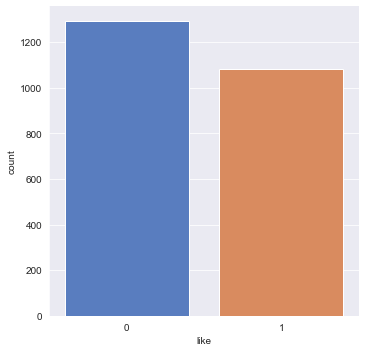

In [10]:
sns.set_palette(sns.color_palette("muted"))
sns.set_style("darkgrid")
sns.catplot(data=adf, x='like', kind='count')

## 3 - Data Exploration



In the data exploration phase, I had three primary goals:

1. **Visualize feature distributions between the two output classes** 
      
       I wanted to see if there were any clear differences in feature distributions between liked and disliked songs. Using histograms and bar plots, I visualized the distributions of the 23 features, and for each, I separated the liked and disliked songs by color.
      

2. **Use statistical tests to analyze predictive ability**
       
       Using ANOVA and Chi-Square tests, I analyzed the predictive ability of the continuous and categorical features, respectively. 

3. **Analyze feature correlation**
       
       I visualized the correlations among the continuous features to analyze the relationships between features. 

In [11]:
# Preparing data (separating into continuous and categorical features)

cont = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
        'instrumentalness', 'liveness', 'valence', 'tempo', 'song_popularity',  
        'album_popularity', 'artist_popularity', 'duration_min']
cat = ['mode', 'time_signature', 'explicit', 'r&b', 'pop', 'rap', 'hip hop', 'funk','rock', 'key']

cont_feats = adf[cont]
cat_feats = adf[cat]

y = adf['like']
liked = adf[adf['like']==1]
disliked = adf[adf['like']==0]

### *Summary Statistics*

There were no obvious outliers or anomalies that I could see from the descriptive statistics.

In [12]:
adf.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,song_popularity,explicit,like,r&b,pop,rap,hip hop,funk,rock,duration_min
count,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,...,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000
mean,0.628416,0.570549,5.311869,-8.775810,0.515993,0.123489,0.343446,0.127747,0.183588,0.476914,...,39.515993,0.295875,0.456229,0.114057,0.456229,0.284933,0.311027,0.047138,0.186448,4.019742
std,0.162311,0.207742,3.543647,3.995365,0.499849,0.125958,0.299976,0.271971,0.154477,0.238437,...,22.781908,0.456531,0.498185,0.317948,0.498185,0.451477,0.463011,0.211979,0.389550,1.497443
min,0.137000,0.002930,0.000000,-42.238000,0.000000,0.022900,0.000009,0.000000,0.025300,0.032100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385117
25%,0.521750,0.435750,2.000000,-10.424250,0.000000,0.039300,0.068875,0.000000,0.095600,0.279000,...,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.197829
50%,0.644000,0.582500,5.000000,-8.022500,1.000000,0.062500,0.271000,0.000108,0.121000,0.471000,...,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.744775
75%,0.750250,0.724000,8.000000,-6.217750,1.000000,0.167000,0.579000,0.032800,0.210000,0.662000,...,57.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.498667
max,0.970000,0.994000,11.000000,-1.140000,1.000000,0.957000,0.996000,0.973000,0.992000,0.982000,...,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.114733


### *Feature Distributions*

Below are the feature distributions of the continuous and categorical predictors, separated by class. The blue bars indicate disliked songs, while the orange bars indicate liked songs. 

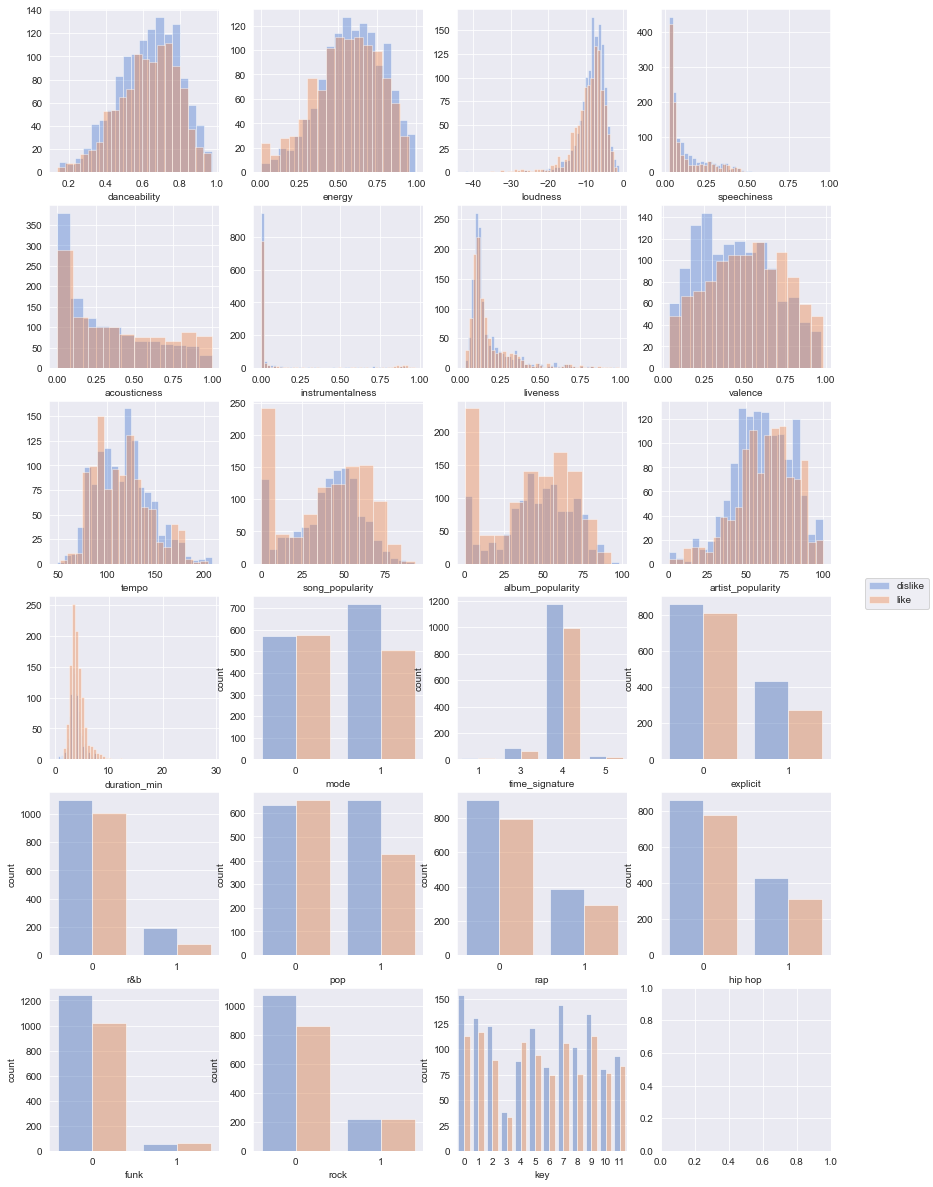

In [13]:
n_row = 6
n_col = 4
num_feat = 0
plots = []
targets = {0: 'disliked', 1: 'liked'}

fig, ax = plt.subplots(n_row, n_col, figsize=(14, 21))

for i in range(n_row):
    for j in range(n_col):  
        
        if num_feat < 13:
            for t, lab  in list(targets.items()):
                plot = sns.distplot(cont_feats.values[y.values==t, num_feat], label=targets[t], kde=False, ax=ax[i][j])
                    
                plot.set_xlabel(cont_feats.columns[num_feat])
            
        elif num_feat < 23:
            plot = sns.countplot(cat_feats[cat_feats.columns[num_feat-13]], hue=adf['like'], ax=ax[i][j], alpha=0.5)
            plots.append(plot)
            plot.legend().remove()
        
        else:
            break
            

        num_feat+=1
        
fig.legend(plots, loc='right', labels=['dislike', 'like'])
fig.show()

Visually, there aren't any striking differences in feature distributions between the liked and disliked songs. However, I did notice a few interesting, minor discrepancies. 

#### Some Observations

- There are more disliked songs of higher energy, loudness, danceability. 

- There are more liked songs of higher valence (happier-sounding songs) and of higher acousticness. There are also more disliked songs of lower valence (sadder-sounding songs) and of lower acousticness. This may indicate a preference towards happier, more acoustic music.

- There are more liked songs of lower popularity (a score of 0-10 in song and album popularity) than there are of higher popularity. There are also more disliked songs of average popularity (a score of 50) than there are liked songs of average popularity.

- The dataset mostly consists of songs that have genres other than the six I selected to one-hot encode. This is indicated by the higher count of 0 in all six count plots of pop, rap, hip hop, funk and rock. 


#### Key Takeaways:

- The higher values of disliked songs (higher blue bars) in the categorical variable distributions can most likely be attributed to the fact that there are slightly more disliked songs than liked songs in our overall dataset.

- Among these 23 features, **the distributions are quite visually similar between the liked and disliked songs.** The differences in the liked and disliked songs may perhaps be discovered through statistical tests and/or feature selection.




It's important to note that Spotify also reported the distributions of their calculated features (mostly the continuous features). The general shape of their distributions are quite similar to the ones above, which indicates that this dataset is a fairly representative sample of the songs on Spotify. The Spotify distributions can be found [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

------ 

### *Statistical Tests – Analyzing Feature Significance*

I conducted the ANOVA and the Chi-Square tests to explore which features have a more significant relationship with the target variable and thus have higher predictive ability. The results of these tests are used below in the model selection phase.


#### ANOVA F-Test

The ANOVA test compares the means and variances across several groups of data. Its results can be used to determine whether or not a significant relationship exists between a number of variables. 

In machine learning, ANOVA can be used to analyze relationships between numeric and categorical variables. In our case, I analyzed the significance of the 13 continuous features on the binary target variable, *like*. Based on the scores below,  the most significant continuous variables are valence, acousticness, loudness, album popularity, duration and energy.

In [14]:
X = adf.loc[:, adf.columns!='like']
y = adf.loc[:, adf.columns=='like']

In [15]:
cols = [col for col in adf.columns if col != 'like']
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(cont_feats, y)

anova_scores = pd.DataFrame({'feature': cont, 'score': fs.scores_})
anova_scores = anova_scores.sort_values(by='score', ascending=False)

anova_scores

,feature,score
7,valence,49.405282
4,acousticness,36.067500
2,loudness,35.266648
10,album_popularity,22.749653
12,duration_min,21.763970
1,energy,21.361626
11,artist_popularity,8.289270
5,instrumentalness,6.549755
8,tempo,3.153940
3,speechiness,2.560480


#### Chi-Square Test

In statistics, Chi-Square tests are used to analyze the independence of two events. Using observed counts O and expected counts E, the test measures how the two sets of counts deviate from one another. 

In machine learning, the test can be used to determine the relevance of categorical input features to the target variable, mostly for the purpose of feature selection. 

Based on the scores below, the most significant categorical variables in our dataset are R&B, pop, mode and hip hop.

In [16]:
fs2 = SelectKBest(score_func=chi2, k='all')
fs2.fit(cat_feats, y)

c2_scores = pd.DataFrame({'feature': cat, 'score': fs2.scores_})
c2_scores = c2_scores.sort_values(by='score', ascending=False)

c2_scores

,feature,score
3,r&b,28.324510
4,pop,16.968781
2,explicit,14.179615
0,mode,9.005820
6,hip hop,4.323268
8,rock,3.599912
7,funk,2.852286
5,rap,1.900710
9,key,0.644858
1,time_signature,0.015547


### *Feature Correlation*

Analyzing correlation among features is a good way to eliminate potential redundancy from a machine learning model. I created a correlation matrix below to visualize these relationships. The matrix shows that there are no correlations stronger than +/- 0.76. The strongest is a positive correlation (0.76) between loudness and energy, which is quite intuitive. The strongest negative correlation (-0.59) is between acousticness and energy. Based on just this information, there isn't any reason to remove any of the features at this point. 

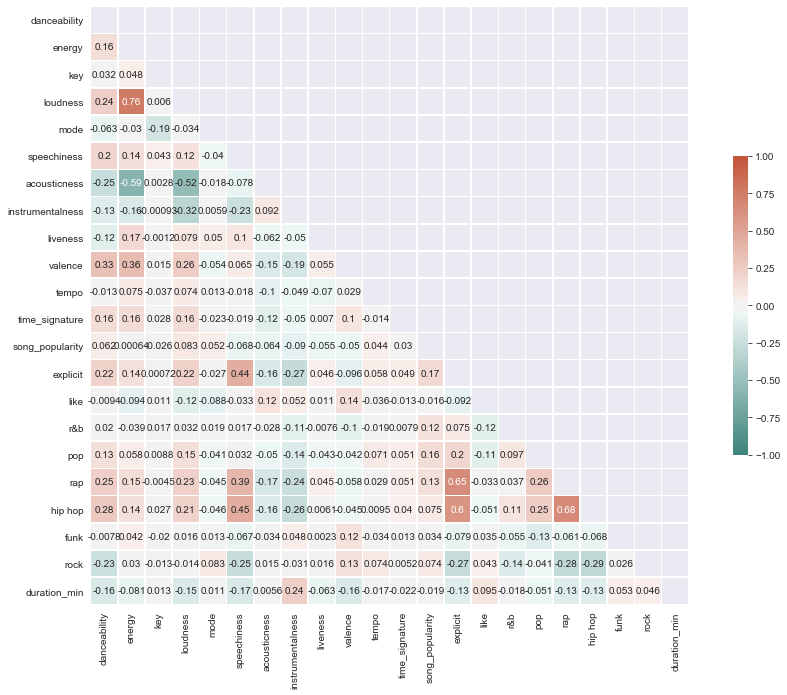

In [17]:
correlation = adf.corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 11))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## (4) Model Selection



- research which models work best on binary classification

Going into this project, I didn't have a particular hypothesis as to which model would perform best on this classification task. I decided I would test several classification models and see the results for myself! I chose 8 models to train and evaluate. 

### *Testing Several Models* 

**Class and Function Definitions**

In [18]:
class SKModel:
    def __init__(self, model):
        if model == 0:
            self.clf = LogisticRegression()
        elif model == 1:
            self.clf = RandomForestClassifier()
        elif model == 2:
            self.clf = LDA()
        elif model == 3:
            self.clf = QDA()
        elif model == 4:
            self.clf = KNeighborsClassifier()
        elif model == 5:
            self.clf = DecisionTreeClassifier()
        elif model == 6: 
            self.clf = GaussianNB()
        elif model == 7:
            self.clf = SVC(probability=True)
        else:
            self.clf = None

        self.cv_k = 10
        self.scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_weighted', 'roc_auc']
        self.scores = pd.DataFrame(columns=['Model','Fitting Time', 'Scoring Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_ROC'])

    def fit(self, X_train, y_train): 
        self.clf.fit(X_train, y_train)

    def generate_predictions(self, X_test):
        predictions = self.clf.predict(X_test)
        return predictions
    
    def cross_validate(self, X_train, y_train, mod):
        sc = cross_validate(self.clf, X_train, y_train, scoring = self.scoring, cv = self.cv_k)
        sorted(sc.keys())
        self.scores['Model'] = [mod]
        self.scores['Fitting Time'] = [sc['fit_time'].mean()]
        self.scores['Scoring Time'] = sc['score_time'].mean()
        self.scores['Accuracy'] = sc['test_accuracy'].mean()
        self.scores['Precision'] = sc['test_precision_macro'].mean()
        self.scores['Recall'] = sc['test_recall_macro'].mean()
        self.scores['F1 Score'] = sc['test_f1_weighted'].mean()
        self.scores['AUC_ROC'] = sc['test_roc_auc'].mean()
    

    def evaluate(self, X_test, y_test):
        accuracy = self.clf.score(X_test, y_test)
        return accuracy
        #print(confusion_matrix(y_test, predictions))
        #print(classification_report(y_test, predictions))

**Train/Test Data Preparation**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1900, 23)
Training Labels Shape: (1900, 1)
Testing Features Shape: (476, 23)
Testing Labels Shape: (476, 1)


**Model Fitting**

In [21]:
log_mod = SKModel(0)
random_forest_mod = SKModel(1)
lda_mod = SKModel(2)
qda_mod = SKModel(3)
knn_mod = SKModel(4)
dec_tree_mod = SKModel(5)
nb_mod = SKModel(6)
svc_mod = SKModel(7)

In [22]:
log_mod.cross_validate(X_train, y_train, 'Logistic Regression')
log_mod.fit(X_train, y_train)
random_forest_mod.cross_validate(X_train, y_train, 'Random Forest')
random_forest_mod.fit(X_train, y_train)
lda_mod.cross_validate(X_train, y_train, 'LDA')
lda_mod.fit(X_train, y_train)
qda_mod.cross_validate(X_train, y_train, 'QDA')
qda_mod.fit(X_train, y_train)
knn_mod.cross_validate(X_train, y_train, 'K-Nearest Neighbors')
knn_mod.fit(X_train, y_train)
dec_tree_mod.cross_validate(X_train, y_train, 'Decision Tree')
dec_tree_mod.fit(X_train, y_train)
nb_mod.cross_validate(X_train, y_train, 'Naive Bayes')
nb_mod.fit(X_train, y_train)
svc_mod.cross_validate(X_train, y_train, 'Support Vector Machine')
svc_mod.fit(X_train, y_train)

In [23]:
models_init = pd.DataFrame(columns=['Model', 'Fitting Time', 'Scoring Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_ROC'])

**Model Evaluation**

In [24]:
models_init = pd.concat([models_init, log_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, random_forest_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, lda_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, qda_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, knn_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, dec_tree_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, nb_mod.scores], ignore_index=True)
models_init = pd.concat([models_init, svc_mod.scores], ignore_index=True)

Below you can see the performance of each of the 8 models, as well as its fitting and scoring time. 

In [25]:
models_init = models_init.sort_values(by='Accuracy', ascending=False)
models_init

,Model,Fitting Time,Scoring Time,Accuracy,Precision,Recall,F1 Score,AUC_ROC
1,Random Forest,0.333717,0.024869,0.704211,0.704492,0.696441,0.701391,0.776947
2,LDA,0.012348,0.005274,0.668421,0.666062,0.662754,0.666694,0.719706
3,QDA,0.004397,0.005420,0.658421,0.656058,0.651313,0.655849,0.716419
0,Logistic Regression,0.034245,0.005747,0.653684,0.650686,0.647496,0.651744,0.708017
7,Support Vector Machine,0.500101,0.022019,0.628421,0.636832,0.609109,0.609091,0.674929
5,Decision Tree,0.020643,0.005537,0.613158,0.611126,0.610290,0.612715,0.611325
4,K-Nearest Neighbors,0.005234,0.014432,0.613158,0.609580,0.607325,0.611305,0.652408
6,Naive Bayes,0.003612,0.005033,0.609474,0.604878,0.601197,0.605894,0.634012


### *Initial Insights*

After evaluating the eight models with 10-fold cross validation, it seems like the Random Forest model performs best with our data. Across all metrics, the model performs ~3% better (on average) than the second-best-performing model tested, LDA. It does however have the second-highest fitting time, at 0.33, which is 30% higher than that of the LDA model. This trade-off between speed and accuracy is an important factor to consider in any model selection. 


For this classification task, I wasn't too concerned with the number of false positives, as long as the true positive rate was high. This meant that, between precision and recall, I was more interested in the latter – as recall concerns false negatives. However, for all the models, it seems like the recall score was slightly worse than both accuracy and precision. This means that there were more false negatives than false positives in the model predictions. In other words, the models predicted more liked songs as disliked than they did predict disliked songs as liked. This can be attributed to information that the algorithms might be missing; they aren't able to pick up on all the reasons why a song is liked. 


The area under the ROC curve was also one metric I was particularly interested in, since it's a good metric to compare classifiers against each other. While there was a slight jump in accuracy from the LDA to the Random Forest, there was an even bigger difference between the models' areas under the ROC curve. This shows that on average – across various classification thresholds – the Random Forest model is better at separating the two classes. This was interesting to me because different people have different "thresholds" for whether or not they like a song. While some are more conservative in their song choices, others are more open and like to explore different types of music. In a binary classification model, this would translate to having predictions with a cut-off of perhaps 0.9 for the more conservative music listener, and a cut-off as low as 0.5 for a liberal music listener. 




**After comparing the various classifiers, I decided to do a deeper dive into the Random Forest model and try several feature selection methods to improve its accuracy.**

### *Exploring the Random Forest Model*


--- 

For this project, I focused on feature selection as a means for improving model performance. As I mentioned at the start, music taste is incredibly subjective, and different people place different weights on song features. While one person might highly value an artist's popularity, another might highly value the musical key of the song (there's definitely someone out there that only listen to songs in the B# key). I wanted to see whether Antoine's data indicates a higher level of importance for some features than others. 

To conduct feature selection, I used two approaches:
        1. ANOVA and Chi-Square Tests
        2. Feature Importance 

#### 1. ANOVA and Chi-Square Tests

Earlier, I conducted ANOVA and Chi-Square tests to analyze which variables had more significant relationships with the target variable, *like*. From these results, I chose the half of each set of variables (continuous and categorical) that had the highest ANOVA test values and Chi-Square test values, respectively. The top 50% was an arbitrary choice for a threshold, so this is a parameter than can be tweaked if it leads to poor performance.

The result was a set of 12 variables, out of the 23 original variables. 

In [26]:
rf_names = list(anova_scores['feature'])[0:8]
rf_names.extend(list(c2_scores['feature'])[0:4])

#### 2. Feature Importance

For each feature, I also used a metric called Feature Importance. This is a metric for tree-based estimators that is calculated by sklearn and evaluates the significance of each feature. Below are the features and their respective importance scores. As you can see, none of the features have an importance score of higher than 0.09. The scores are within a range of 0.084, and there aren't drastic jumps in feature importance scores when the list is ordered. 

In [27]:
importances = list(random_forest_mod.clf.feature_importances_)

feat_imps = pd.DataFrame({'features': list(X.columns), 'importances': importances})
feat_imps = feat_imps.sort_values(by='importances', ascending=False)

feat_imps

,features,importances
12,song_popularity,0.087564
9,valence,0.087348
6,acousticness,0.074631
14,album_popularity,0.074351
15,artist_popularity,0.070122
3,loudness,0.069414
22,duration_min,0.067115
10,tempo,0.064669
1,energy,0.063041
5,speechiness,0.060344


Below is a graph that shows the additional importance contribution of each feature, starting with the feature of highest importance, *song popularity*. The dashed line is set at 95% of the overall importance.

I used this to select a subset of 'most important' features, in order to train the Random Forest model. The cut off was at 17 features, with *hip hop* being the last 'most important' feature. 95% is also an arbitrary threshold, but can be adjusted given the performance of the model. 

Text(0.5, 1.0, 'Cumulative Importances')

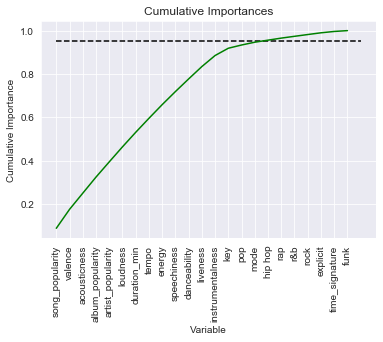

In [37]:
cum_imp = np.cumsum(feat_imps['importances'])
plt.plot(list(range(len(feat_imps))), cum_imp, 'g-')
plt.hlines(y=0.95, xmin=0, xmax=len(feat_imps['features']), linestyles='dashed')

plt.xticks(list(range(len(feat_imps))), feat_imps['features'], rotation='vertical')
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

In [38]:
rf_imp_names = list(feat_imps['features'])[0:17]

-----

**Training and Evaluating on the Reduced Features**

Now it's time to train and evaluate separate Random Forest models on these two subsets of features. 

In [45]:
X_train_rf = X_train.loc[:, rf_names]
X_test_rf = X_test.loc[:, rf_names]

X_train_imp = X_train.loc[:, rf_imp_names]
X_test_imp = X_test.loc[:, rf_imp_names]


print('Important train features shape: ', X_train_imp.shape)
print('Important test features shape: ', X_test_imp.shape)

print('RF train features shape: ', X_train_rf.shape)
print('RF test features shape: ', X_test_rf.shape)

Important train features shape:  (1900, 17)
Important test features shape:  (476, 17)
RF train features shape:  (1900, 12)
RF test features shape:  (476, 12)


In [46]:
rf_mod_reduced = SKModel(1)
rf_mod_reduced.fit(X_train_rf, y_train)
rf_mod_reduced.cross_validate(X_train_rf, y_train, 'RF Reduced w/ Stat Tests')

rf_mod_imp = SKModel(1)
rf_mod_imp.fit(X_train_imp, y_train)
rf_mod_imp.cross_validate(X_train_imp, y_train, 'RF Reduced w/ Importances')

In [47]:
scores_rf = pd.DataFrame(columns=['Model', 'Fitting Time', 'Scoring Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_ROC'])
scores_rf = pd.concat([scores_rf, rf_mod_reduced.scores], ignore_index=True)
scores_rf = pd.concat([scores_rf, rf_mod_imp.scores], ignore_index=True)
scores_rf = scores_rf.append(models_init.iloc[0, :], ignore_index=True)

scores_rf['Num Features'] = [len(rf_names), len(rf_imp_names), len(X.columns)]
scores_rf = scores_rf.sort_values(by='Accuracy', ascending=False)

In [48]:
scores_rf

,Model,Fitting Time,Scoring Time,Accuracy,Precision,Recall,F1 Score,AUC_ROC,Num Features
2,Random Forest,0.333717,0.024869,0.704211,0.704492,0.696441,0.701391,0.776947,23
1,RF Reduced w/ Importances,0.363095,0.024489,0.701053,0.701082,0.694197,0.698639,0.767965,17
0,RF Reduced w/ Stat Tests,0.298321,0.026461,0.694211,0.693343,0.686569,0.691443,0.748955,12


### *More Insights*

Above you can see a comparison in performance metrics among the three Random Forest models. While the original RF model, with all 23 features, has the highest accuracy of 70.4%, the second best model (with features selected using feature importance) has an accuracy of 70.1% – just under a 0.3% difference.
The model with the worst accuracy among the three (features selected using stat tests) also only performs worse by 1%. 

This says a lot about the features included in this model – they probably weren't all that useful! **The difference in performance among the models with 23 features, 17 features, and 12 features is pretty trivial.** This may indicate that around half of the features used in this model were not all that significant in predicting whether Antoine would like a song or not. This could have to do with his eclectic music taste, the choice in model, or just plainly that these predictors aren't very.. predictive for this task. 

Another observation to note is that, weidly enough, the fitting time of the RF with 17 features was slightly higher than the original RF model. Usually with fewer features, fitting time would decrease (which is good) but the accuracy would also decrease (which it did). 

It is also worth noting that the gravity of differences in accuracy depends on the task at hand. While a difference of 2% may be significant in ML applications that involve life or death, it's arguably not all that devastating in this case. 

------

## 5 - Results

At this point, I do want to state that I knew from the start how difficult of a task it would be to predict whether a person with eclectic music taste would like a song or not. Music taste is not only **so subjective** but it also **varies in subjectivity from person to person.** While that makes for a complex problem to solve, it also offers up an exciting machine learning challenge – especially for someone who loves music!

Here are some of the key takeaways I had from attempting this challenge: 
1. **A person's *type* of music taste matters**  
        With these features, it would probably be easier to predict song likability for a person if they had a narrower music taste – meaning they only conservatively listened to specific genres or artists. Someone with a more varied music taste would have higher variance within these feature values (as Antoine did), and it would be harder to predict their song preferences. 
        
        
2. **This model could be improved more predictive features**
        While these features can predict song likability for Antoine fairly well, they could certainly be added upon. Other features to include are recency of song release, popularity based on Billboard charts, and even social media following. And to dive even deeper, user data on number of listens, favorite artists, song skips and song saves would most likely be significant features in predicting song likability. 



To improve or build upon this project in the future, here are a few things I would do: 
- Improving current Random Forest model by hyperparameter tuning
- Implementing other models (like Neural Networks)
- Gathering more data about each song (finding more/better features)



## 6 - Implementations

There are many implications of a model that can accurately predict whether or not a person will like a song. One significant application are recommender systems – popularized in the machine learning field by the Netflix Challenge – which are used by companies like Spotify and Pandora. Understanding a listener's "music profile" will allow for a more personalized music listening experience and can change the way music discovery takes place. It could also influence other areas in the music industry, like A&R strategy. 


#### My Own Implementation

I used the RF model with the highest accuracy to create an app, which I titled *Discover Friendly*. One of the best ways to discover new music is through friends, so I thought – what if that could be augmented with some machine learning? The app recommends songs to Antoine (since this model is only trained on his data), from *my own* music library. Think of it as an AI-powered playlist generator! You can play around with it [here](https://discover-friendly.herokuapp.com/), and let me know what you think!

----- 

#### <center> Please reach out if you have any comments or recommendations! I'd love to chat. </center> 

Github: https://github.com/jannalouisea


LinkedIn: https://www.linkedin.com/in/janna-agustin/